## 2. A, C and Z frequency weightings

After we compensate the input signal by means of the designed inverse filter, the next step is to pass its output to the **frequency weighting network**.

The purpose of these frequency weighting networks is to adapt the measurements results to the **natural behaviour of the human ear**. As we know, **the relationship between the subjective perception of sound intensity (loudness) and the actual sound pressure level is not linear throughout the frequency spectrum**. We are more sensitive in the frequency range from around 500 Hz to 6 kHz. Moreover, **this behaviour varies with the actual sound pressure level of the signal**.

The **A frequency weighting** provides a way to take into account the loudness percieved throughout the frequency spectrum as compared to a **1 kHz tone at 40 dBSPL**, this is know as **40 fons**. On the other hand, the **C frequency weighting** applies the same logic but at a **100 fon** level. As for the **Z frequency weighting** well, it actually means no weighting at all ¯\\_(ツ)_/¯.

## Designing the filters

The frequency weighitngs that are used on sound level meters are defined in the **IEC 61672 standard**. In it the tolerance limits are defined for the three mentioned weightings, as well as the **procedure to correctly design them**.

The standard specifies the **transfer function** that describes each filter, for the case of the **A-weighting filter** this is:

$$A(s)= \dfrac{1.2589049 \ x \ 76617.2^2s^4}{(s + 129.43)^2(s + 676.7)(s + 4636.36)(s + 76617.2)^2}$$

Since this equation is given in the **analog complex-frequency _s_-domain** we need to map that to the **_z_ digital domain**. This is done through the **Laplace transform** and applying the **bilinear transform**. This way we can then **implement a digital filter based on this equation**.

The **digital filter** will be **defined by the location of the poles and zeros the within the unit-circle**. We'll define the **zero-pole-gain system** for the **A and C frequency weightings**, as extracted from the standard and do the necessary steps to obtain our digital filters.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,9)
sns.set_context('notebook', font_scale=1.2)

## Zero-pole-gain system calculated
## from the IEC 61672 standard
## - - - - - - - - - - - - - - -

# C-weighting
Z_C = np.array([0, 0])
P_C = np.array([-2*np.pi*20.598997057568145, 
                -2*np.pi*20.598997057568145,
                -2*np.pi*12194.21714799801,
                -2*np.pi*12194.21714799801])
K_C = (10**(0.062/20))*P_C[3]**2

# A-weighting
Z_A = np.append(Z_C, [0, 0])
P_A = np.insert(P_C, 
                [2, 2], 
                [-2*np.pi*107.65264864304628, 
                -2*np.pi*737.8622307362899])
K_A = (10**(2/20))*P_A[4]**2

Having our **zero-pole-gain systems** we can start to design the filters. As we can see **the coefficients for the A-weighting filter draw from the ones given for the C-weighting**.

## Plotting the weightings' frequency response

First, before doing the transformation from the analog _s_-domain to the digital _z_-domain, let's plot the filters as defined in the standard.

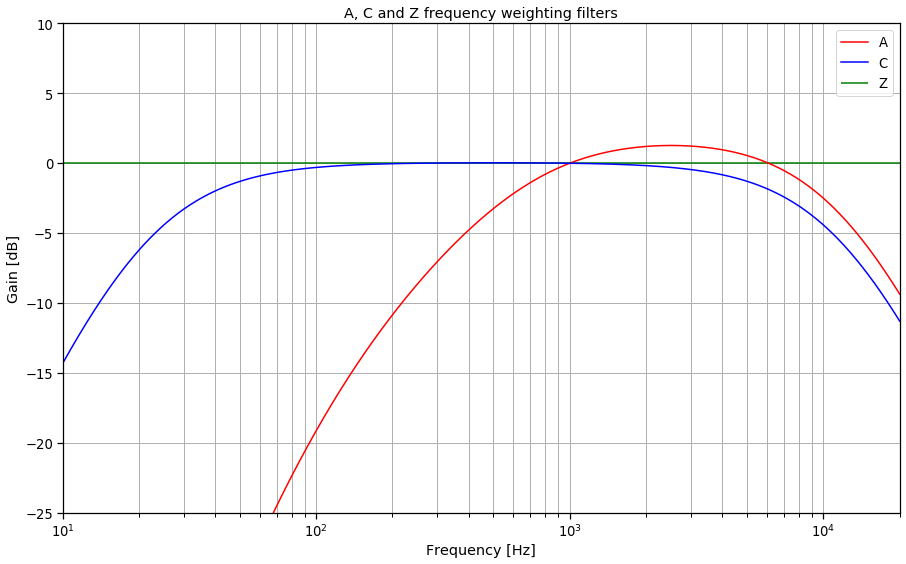

In [77]:
from scipy.signal import freqs_zpk

W_A, H_A = freqs_zpk(Z_A, P_A, K_A, worN=10**4)
W_C, H_C = freqs_zpk(Z_C, P_C, K_C, worN=10**4)

plt.plot(W_A/(2*np.pi), 20*np.log10(abs(H_A)), color='r', label='A')
plt.plot(W_C/(2*np.pi), 20*np.log10(abs(H_C)), color='b', label='C')
plt.hlines(y=0, xmin=0, xmax=10**5, color='g', label='Z')

plt.xscale('log')
plt.title('A, C and Z frequency weighting filters')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.legend()
plt.grid('on', which='both')
plt.ylim([-25, 10])
plt.xlim([10, 20000]);

Above, we can see clearly the **effect of each weighting filter on the signal**. 

The **A-weighting filter is the most common in acoustical measurements**, and as displayed it **under-estimates the lower end of the frequency spectrum, giving more importance to the frequencies from 1 kHz to 6 kHz**. The **C-weighting filter, that follows the response of the ear at higher sound pressure levels, has a gentler pass-band curve as it has an almost linear response between 100 Hz and 2 kHz**.

## From the analog to the digital domain

Next, we'll **define and apply the bilinear transformation that will allow us to design a digital filter** based on the provided transfer function.

In [31]:
# sampling frequency
FS = 44100

def bilinear_zpk(z, p, k, fs=44100):
    """ Returns the zero-pole-gain system in the z-domain
    from the same system in the s-domain through the bilinear
    transform. """
    deg = len(p) - len(z)
    fs2 = 2.0*fs
    # Bilinear transform
    z_b = (fs2 + z)/(fs2 - z)
    p_b = (fs2 + p)/(fs2 - p)
    z_b = np.append(z_b, -np.ones(deg))
    k_b = k*np.real(np.prod(fs2 - z)/np.prod(fs2 - p))
    return z_b, p_b, k_b

Now, let's get transform our zero-pole-gain system from the _s_-plane to the _z_ unit circle. After that we can calculate **the coefficients to apply this zero-pole-gain system as a filter in cascading second-order-sections**.

In [55]:
from scipy.signal import zpk2sos

sos_A = zpk2sos(*bilinear_zpk(Z_A, P_A, K_A))
sos_C = zpk2sos(*bilinear_zpk(Z_C, P_C, K_C))

# saving
#np.save('../src/sos_A.npy', sos_A)
#np.save('../src/sos_C.npy', sos_C)

We have our coefficients, awesome! Now, let's compare the **ideal frequncy response defined by the standard with the filters we have designed**.

Spoiler alert: **the bilinear transform introduces error** in process of mapping the analog domain to the digital domain. This is know as **frequency warping** and is **noticeable in the upper-end of the spectrum** (closet to the Nyquist frequency).

We'll show one plot for each of the two frequency weightings, comparing the **designed digital filter with the response defined by the standard.

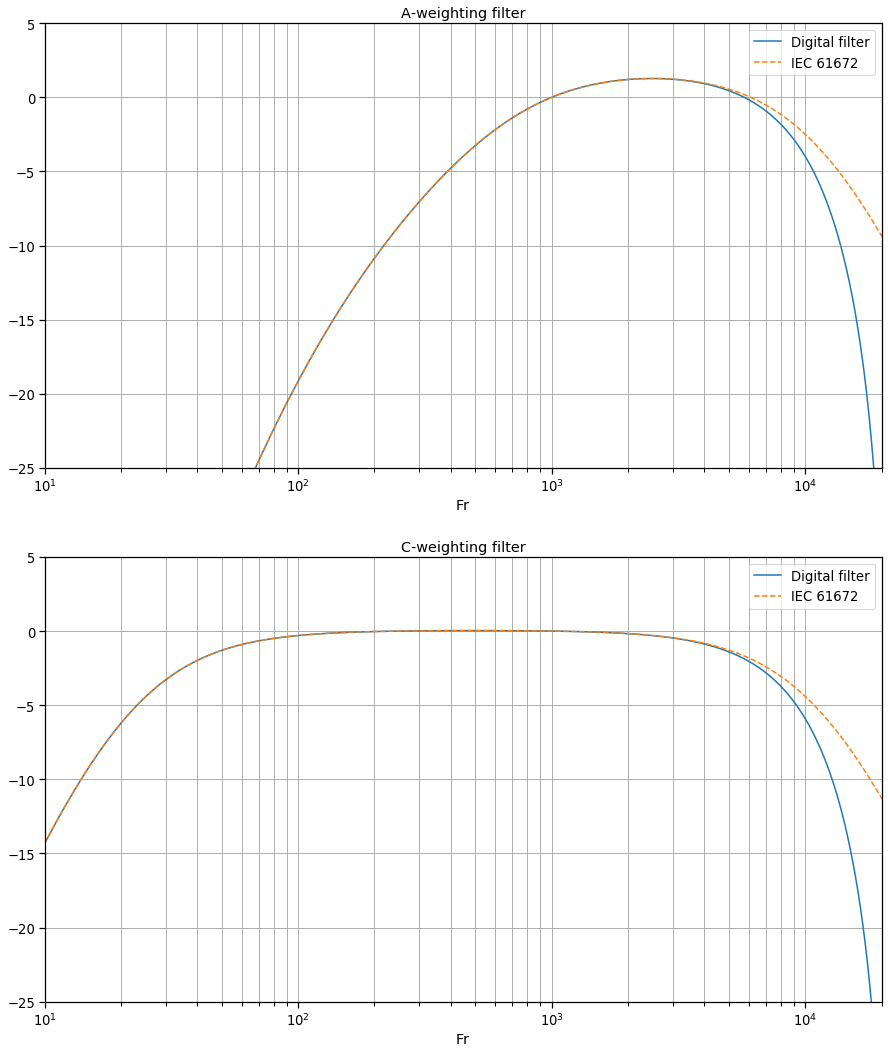

In [116]:
from scipy.signal import sosfreqz

w_a, h_a = sosfreqz(sos_A, worN=2*10**4)
w_c, h_c = sosfreqz(sos_C, worN=2*10**4)

# minimum representable float to avoid division by zero in log10
eps = np.finfo(float).eps

fig, ax = plt.subplots(2, 1, figsize=(15,18))

ax[0].plot((0.5*FS/np.pi)*w_a, eps+20*np.log10(abs(h_a+eps)), label='Digital filter')
ax[0].plot(W_A/(2*np.pi), 20*np.log10(abs(H_A)), '--', label='IEC 61672')

ax[1].plot((0.5*FS/np.pi)*w_c, eps+20*np.log10(abs(h_c+eps)), label='Digital filter')
ax[1].plot(W_C/(2*np.pi), 20*np.log10(abs(H_C)), '--', label='IEC 61672')

ax[0].set_title('A-weighting filter')
ax[1].set_title('C-weighting filter')

for ax_ in ax:
    ax_.set_xscale('log')
    ax_.grid('on', which='both')
    ax_.legend()
    ax_.set_xlabel('Fr')
    ax_.set_xlim([10, 20000])
    ax_.set_ylim([-25, 5])

Despite the fact that the **designed A-weighting filter has a difference above 24 dB ath 20 kHz, this frequency is below the standard's  tolerance interval for its Class 1 specification**.

To wrap up we'll **apply both weightings to the field recording snippet** we went through in the last Notebook. Then, we'll **compare by hearing and plotting the frequency-response obtained after applying both weighting filters**

In [162]:
## TODO: Import as package

def smooth_spectrum(X, freq, Noct=3):
    """ Apply a 1/Noct smoothing to the input frequency spectrum 'X'
    at the 'freq' frequencies.
    Calculates the i-th smoothed spectral coefficient 'X_oct(i)' as 
    the sum of the windowed spectrum. The window is a Gaussian whose
    center frequency is 'freq(i)', and whose sigma is proportional
    to 'freq(i)/Noct'. """
    # initial spectrum
    X_oct = X.copy()
    if Noct > 0:
        for i in np.arange(np.where(freq>0)[0][0], len(freq)):
            g = gauss_f(freq=freq, f0=freq[i], Noct=Noct)
            X_oct[i] = sum(g*X)
    # avoid undershoot
    if min(X) >= 0:
        X_oct[X_oct<0] = 0
    return X_oct

def gauss_f(freq, f0, Noct):
    """ Calculate frequency-domain Gaussian with unity gain. 
    Inputs:
    freq: array of frequencies in which to do the computation.
    f_0: center frequency.
    Noct: determines the bandwith as f_0/Noct. """
    # standard deviation
    sigma = (f0/Noct)/np.pi
    # Gaussian
    g = np.exp(-(((freq-f0)**2)/(2*(sigma**2))))
    # magnitude normalizaition
    return g/sum(g)

def spec(x, nfft=2**12, fs=FS):
    """ Compute the FFT spectrum of the input audio signal 'x'. 
    The number of points for which to compute the FFT can be 
    specified by 'nfft'. Its possible to select a Hanning or Flattop
    window, in which case corrections are applied to obtain accurate 
    measurements based on the spectrum. """
    freq = fs/2*np.linspace(0, 1, int(nfft/2)+1)  # FFT frequency vector
    sp = np.fft.rfft(x, nfft)
    spp = np.abs(sp)/nfft
    return spp, freq
"""
def ref_f(x, f):
    
    idx = (np.abs(f-1000)).argmin()
    return x-x[idx]
"""

'\ndef ref_f(x, f):\n    \n    idx = (np.abs(f-1000)).argmin()\n    return x-x[idx]\n'

In [165]:
import ipywidgets
import IPython

# creating widgets
rec_A = IPython.display.Audio(x_A, rate=fs)
rec_C = IPython.display.Audio(x_C, rate=fs)

# displaying
print('A-weighted')
IPython.display.display(rec_A)
print('C-weighted')
IPython.display.display(rec_C)

A-weighted


C-weighted


If you hear both audios it's possible to appreciate the **difference in the lower end of the spectrum**.



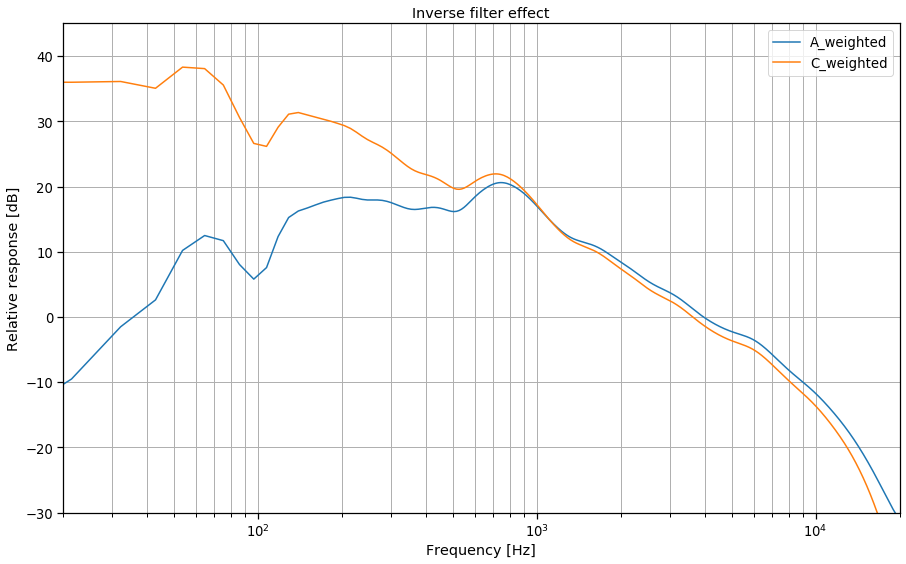

In [164]:
from scipy.signal import sosfilt
from scipy.io import wavfile 
# load audio
fs, field = wavfile.read('../aud/field.wav')

# limiting audio length to 5 seconds
T_LEN = 5
start = np.random.randint(len(field)-(fs*T_LEN))
end = start + fs*T_LEN
x = field[start:end]

# applying both weighting filters to the audio
x_A = sosfilt(sos_A, x)
x_C = sosfilt(sos_C, x)

# getting the responses for both signals
X_A, freq,  = spec(x_A, nfft=2**12)
X_C, _ = spec(x_C, nfft=2**12)

# plotting the absolute value of the FFTs
plt.semilogx(freq, 20*np.log10(smooth_spectrum(X_A, freq)), label='A-weighted')
plt.semilogx(freq, 20*np.log10(smooth_spectrum(X_C, freq)), label='C-weighted')

plt.xlim([20, 20000])
plt.ylim([-30, 45])
plt.title('Inverse filter effect')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Relative response [dB]')
plt.legend()
plt.grid(which='both', axis='both');

## Conclusion

[...]